In [3]:
from datetime import datetime
import yfinance as yf
import backtrader as bt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

# RSI Strategy

In [4]:
class RSILimit(bt.Strategy):
    
    def __init__(self):
        self.rsi = bt.indicators.RSI_SMA(self.data.close, period=14)

    def next(self):
        if not self.position:  # not in the market
            if self.rsi <= 30 :  
                self.buy()  # enter long

        elif self.rsi >= 70:  # in the market & cross to the downside
            self.close()  # close long position

cerebro = bt.Cerebro(stdstats=False)

# add analytics
cerebro.addobserver(bt.observers.Value)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.BuySell, barplot=True, bardist=0.02)

cerebro.addstrategy(RSILimit)

data0 = bt.feeds.GenericCSVData(dataname='../data/BTC-USD-backtrader.csv',
                                fromdate=datetime(2022, 1, 1, 0, 0, 0),
                                todate=datetime(2022, 4, 1, 0, 0, 0),
                                nullvalue=0.0,
                                dtformat=('%Y-%m-%d %H:%M:%S'),
                                #tmformat=('%H:%M:%S'),
                                
                                datetime=0,
                                #time=1,
                                low=1,
                                high=2,
                                open=3,
                                volume=4,
                                close=5,
                                openinterest=-1,)
cerebro.adddata(data0)

cerebro.broker.setcash(10000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.addsizer(bt.sizers.FixedSize, stake=0.05)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000.00
Final Portfolio Value: 6138.36


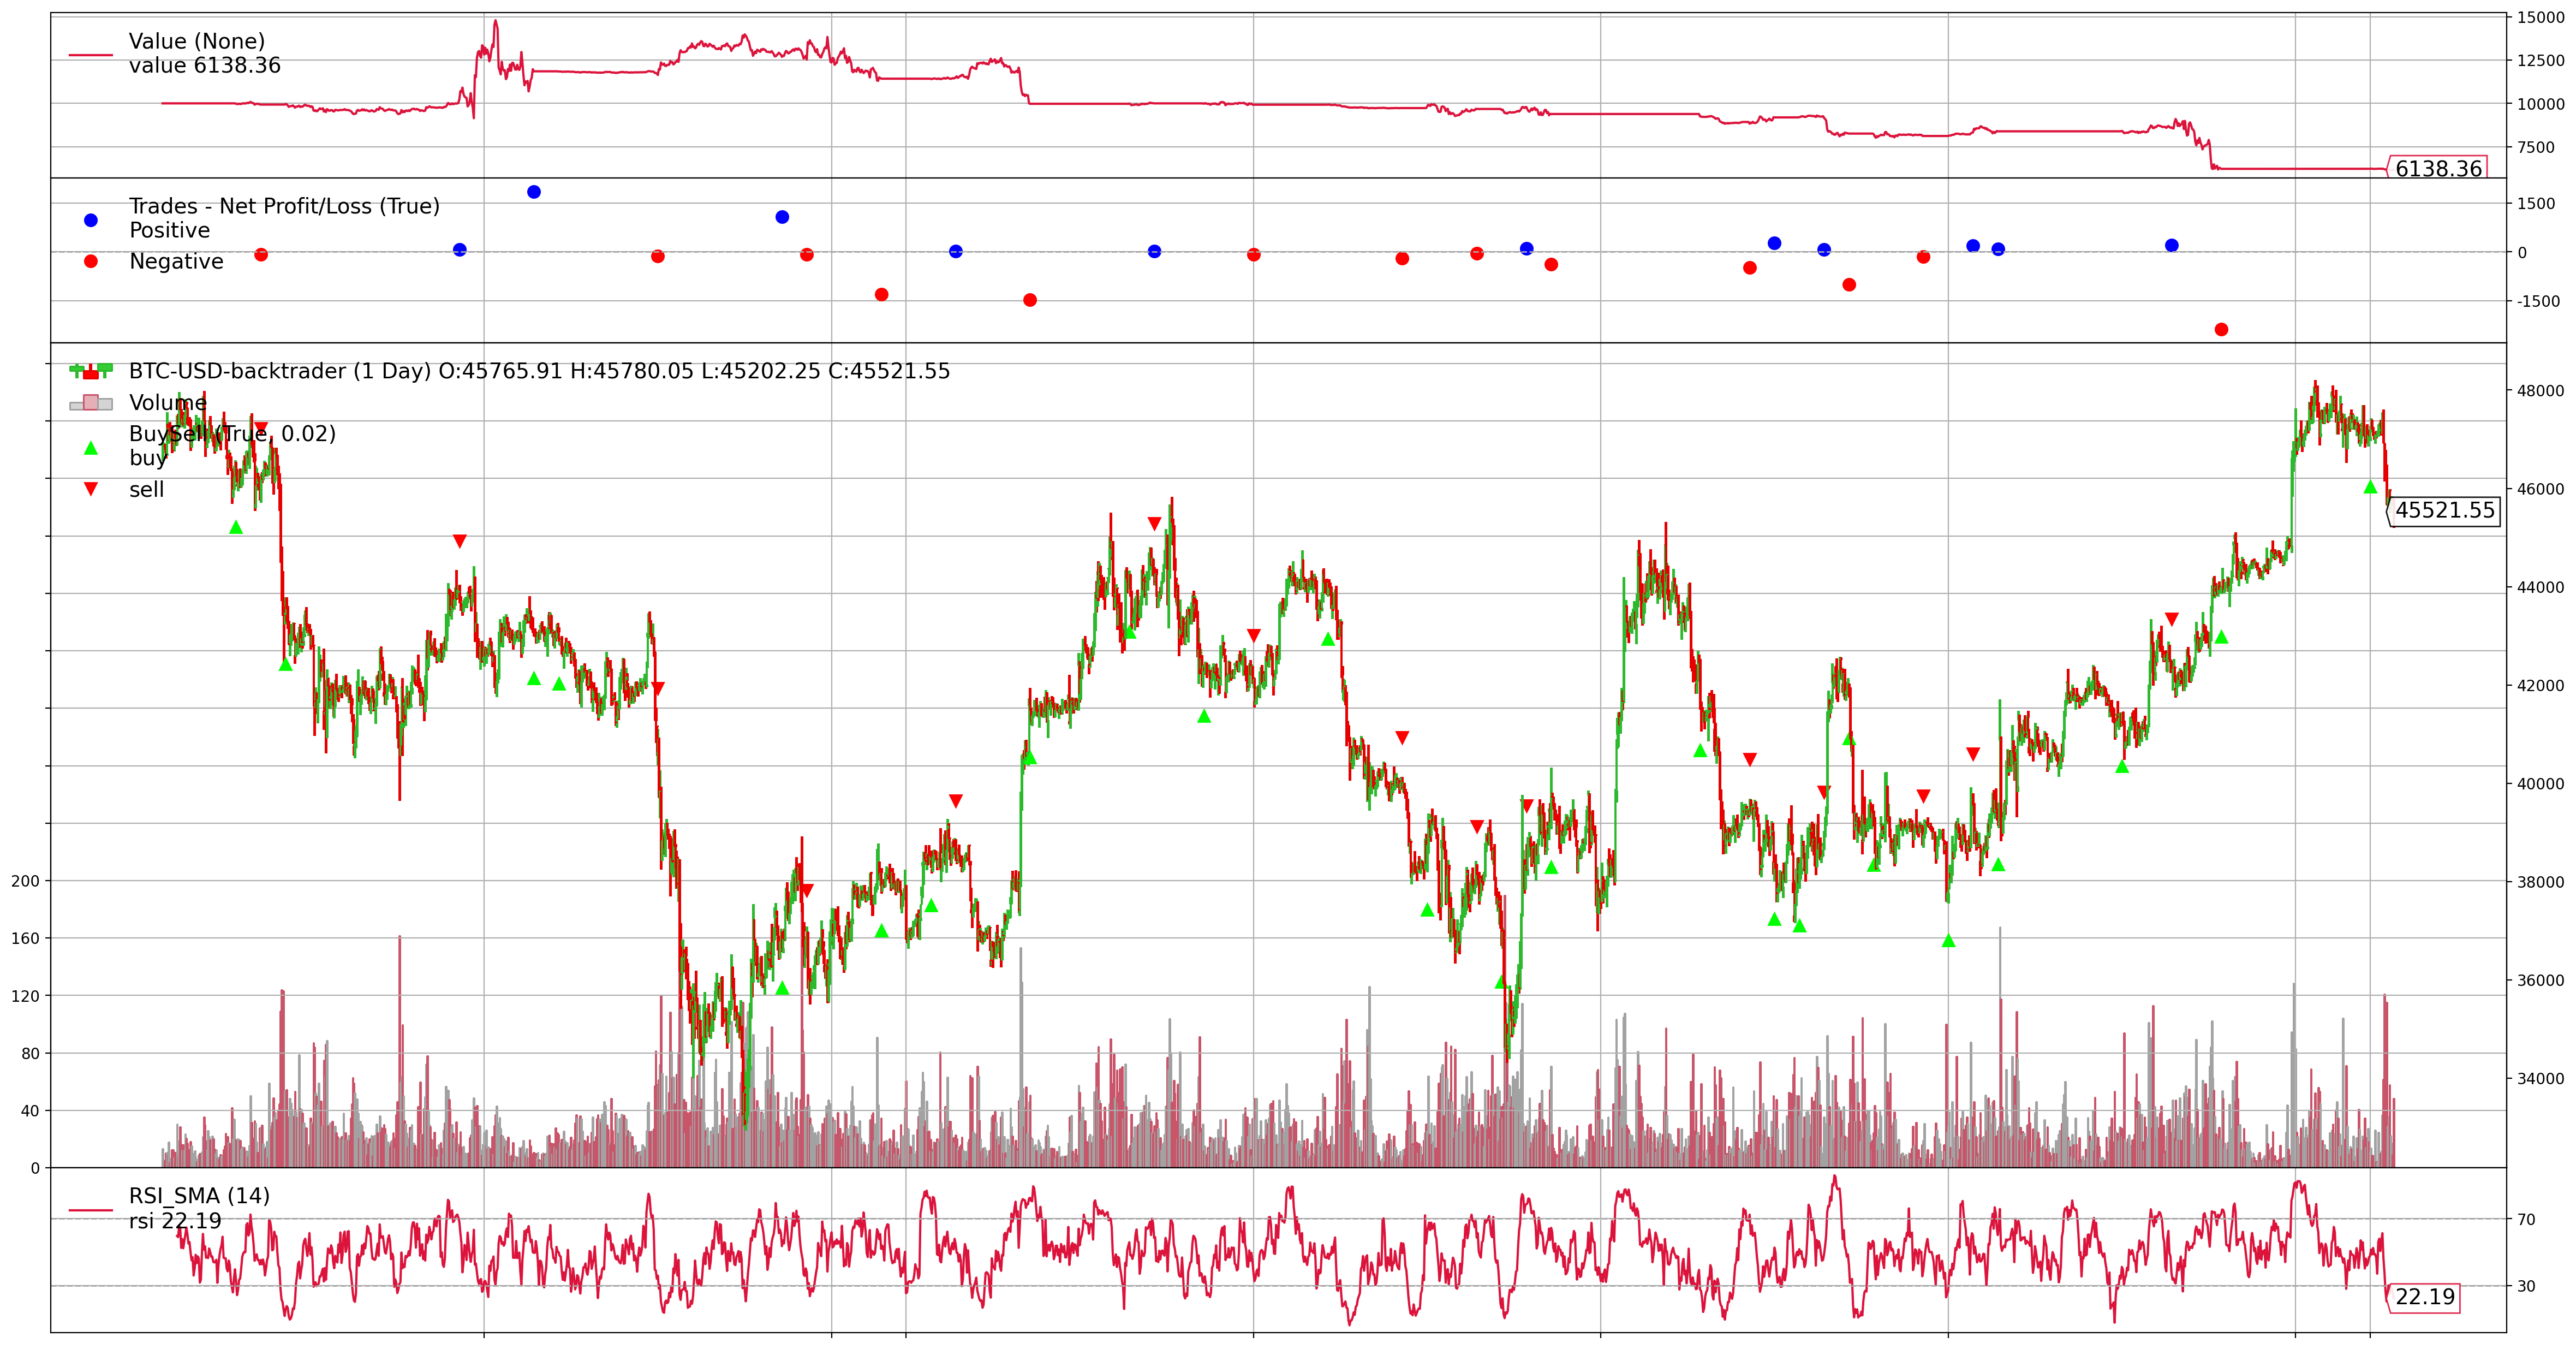

[[<Figure size 5000x2600 with 5 Axes>]]

In [5]:
# Plot the result
plt.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.figsize']=[25, 13]
plt.rcParams['figure.dpi']=200
plt.rcParams['figure.facecolor']='w'
plt.rcParams['figure.edgecolor']='k'
cerebro.plot(iplot = False, subtxtsize = 14, style = 'candle', barup='limegreen', bardown='red')

# SMA Strategy

In [7]:
class SmaCross(bt.Strategy):
    # list of parameters which are configurable for the strategy
    params = dict(
        pfast=10,  # period for the fast moving average
        pslow=20   # period for the slow moving average
    )

    def __init__(self):
        sma1 = bt.ind.SMA(period=self.p.pfast)  # fast moving average
        sma2 = bt.ind.SMA(period=self.p.pslow)  # slow moving average
        self.crossover = bt.ind.CrossOver(sma1, sma2)  # crossover signal

    def next(self):
        if not self.position:  # not in the market
            if self.crossover > 0:  # if fast crosses slow to the upside
                self.buy()  # enter long
        elif self.crossover < 0:  # in the market & cross to the downside
            self.close()  # close long position

cerebro = bt.Cerebro(stdstats=False)

# add analytics
cerebro.addobserver(bt.observers.Value)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.BuySell, barplot=True, bardist=0.02)

cerebro.addstrategy(SmaCross)

data0 = bt.feeds.GenericCSVData(dataname='../data/BTC-USD-backtrader.csv',
                                fromdate=datetime(2022, 1, 1, 0, 0, 0),
                                todate=datetime(2022, 4, 1, 0, 0, 0),
                                nullvalue=0.0,
                                dtformat=('%Y-%m-%d %H:%M:%S'),
                                #tmformat=('%H:%M:%S'),
                                
                                datetime=0,
                                #time=1,
                                low=1,
                                high=2,
                                open=3,
                                volume=4,
                                close=5,
                                openinterest=-1,)
cerebro.adddata(data0)

cerebro.broker.setcash(10000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.addsizer(bt.sizers.FixedSize, stake=0.05)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000.00
Final Portfolio Value: 9622.81


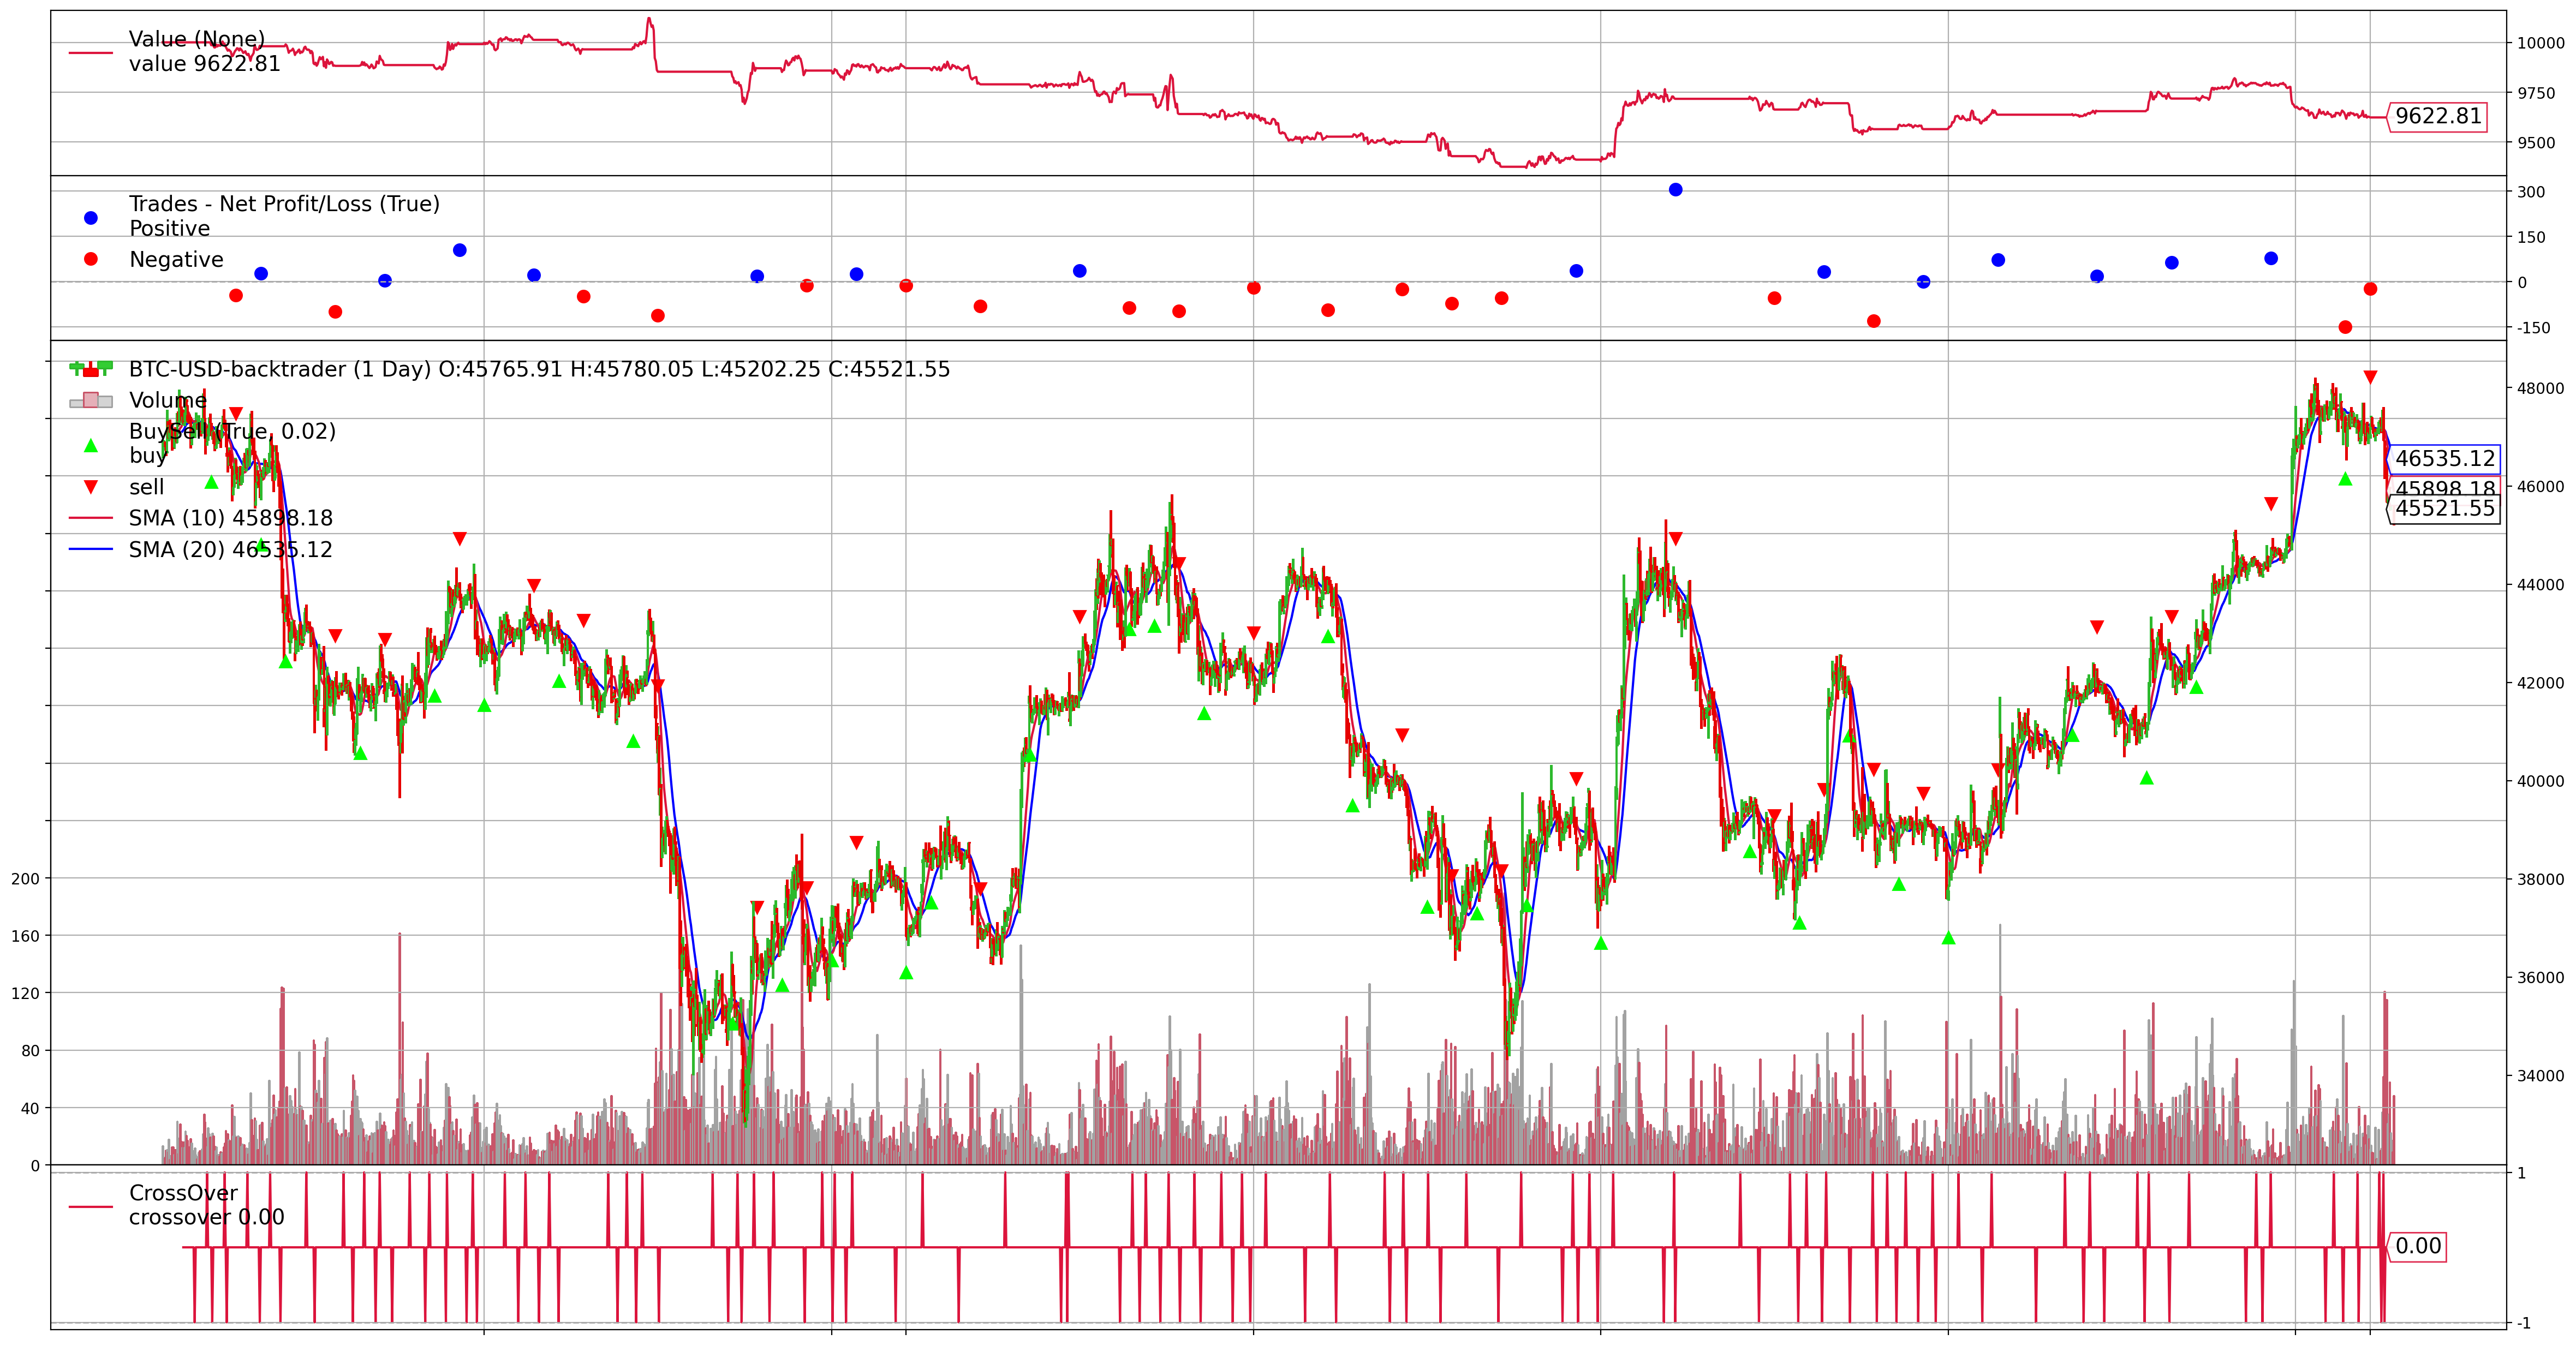

[[<Figure size 5000x2600 with 5 Axes>]]

In [8]:
# Plot the result
plt.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.figsize']=[25, 13]
plt.rcParams['figure.dpi']=200
plt.rcParams['figure.facecolor']='w'
plt.rcParams['figure.edgecolor']='k'
cerebro.plot(iplot = False, subtxtsize = 14, style = 'candle', barup='limegreen', bardown='red')

# Strategy based on the Prediction of the Deep Learning Model

In [10]:
class DLICross(bt.Strategy):
    
    def __init__(self):
        self.dli1 = self.data.l.dli1
        self.dli2 = self.data.l.dli2
        self.crossover = bt.ind.CrossOver(self.dli1, self.dli2)  # crossover signal
        self.sma1 = bt.ind.SMA(period=10)
        self.sma2 = bt.ind.SMA(period=20)
        
    def next(self):
        if not self.position:  # not in the market
            if self.crossover > 0: 
                self.buy()  # buy bitcoin
        elif self.crossover < 0 and self.sma1 < self.sma2:
            self.close() # sell bitcoin


cerebro = bt.Cerebro(stdstats=False)

# add analytics
cerebro.addobserver(bt.observers.Value)
cerebro.addobserver(bt.observers.Trades)
#cerebro.addobserver(bt.observers.DrawDown)
#cerebro.addobserver(bt.observers.TimeReturn)
cerebro.addobserver(bt.observers.BuySell, barplot=True, bardist=0.025)
cerebro.addstrategy(DLICross)



class MyHLOC(bt.feeds.GenericCSVData):
    
    lines = ('dli1','dli2',)
    
    params = (
        ('fromdate', datetime(2022, 1, 1, 0, 0, 0)),
        ('todate', datetime(2022, 4, 1, 0, 0, 0)),
        ('nullvalue', 0.0),
        ('dtformat', ('%Y-%m-%d %H:%M:%S')),

        ('datetime', 0),
        ('low', 1),
        ('high', 2),
        ('open', 3),
        ('volume', 4),
        ('close', 5),
        ('dli1', 6),
        ('dli2', 7),
        ('openinterest', -1))


data0 = MyHLOC(dataname='../data/BTC-USD-backtrader.csv')


cerebro.adddata(data0)

cerebro.broker.setcash(10000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.addsizer(bt.sizers.FixedSize, stake=0.05)


# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000.00
Final Portfolio Value: 17395.88


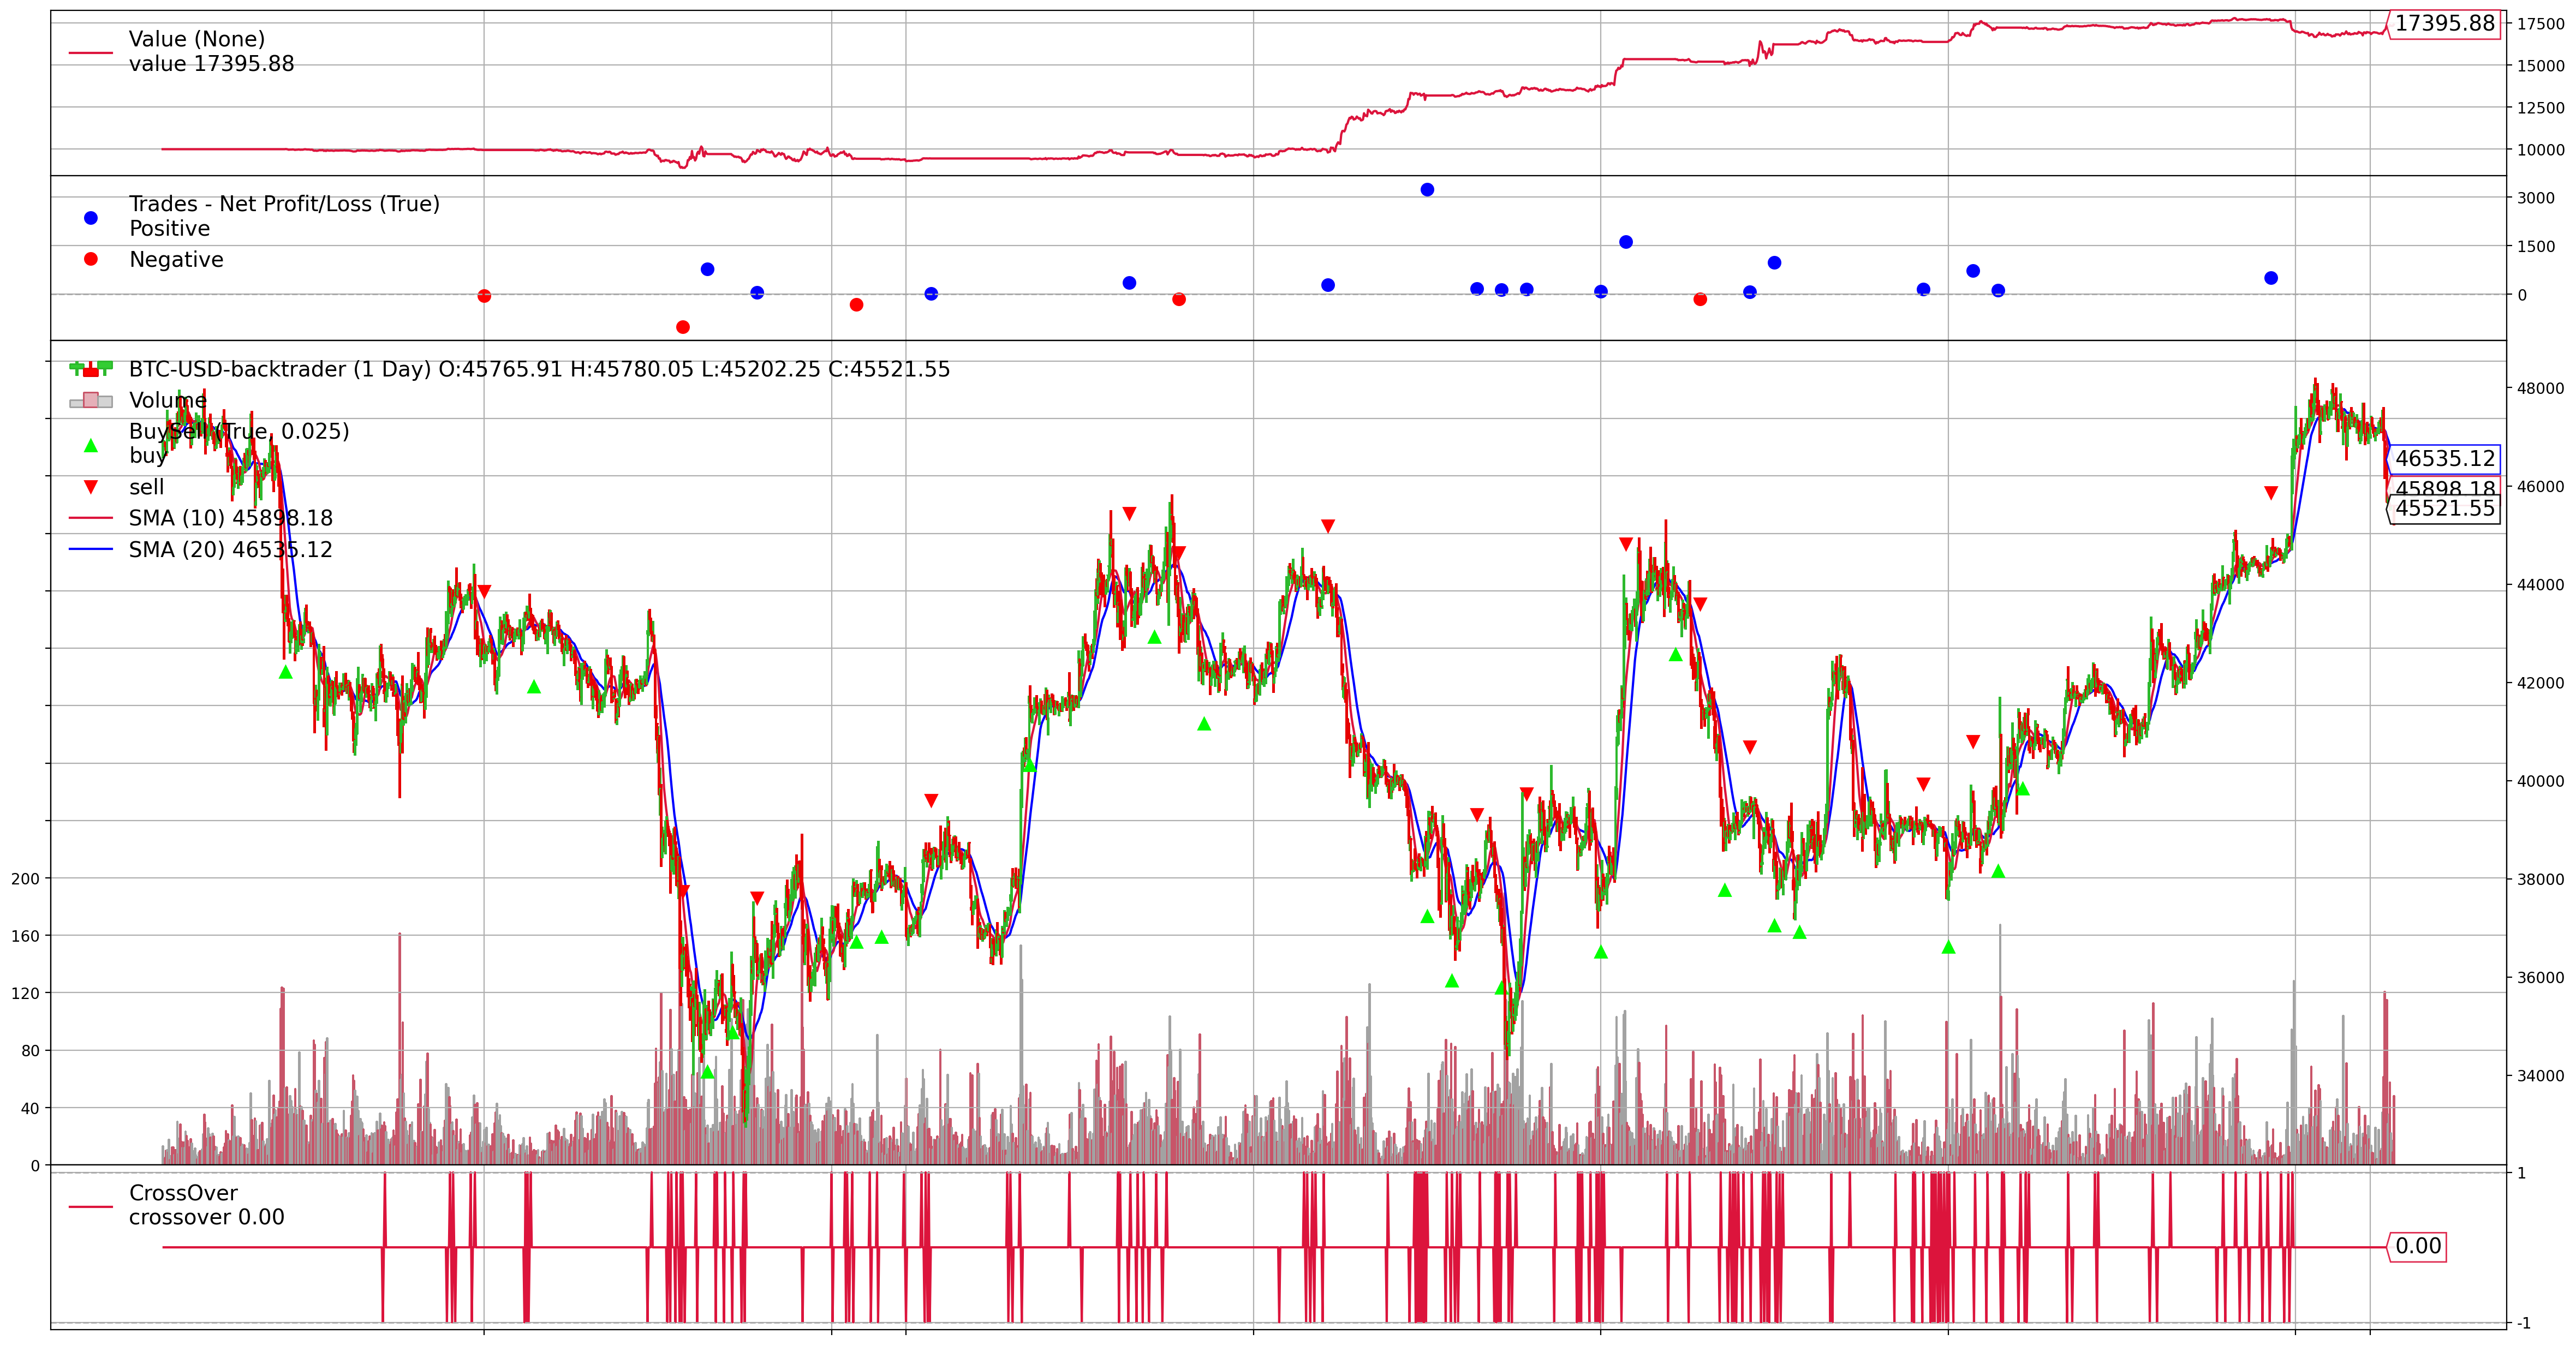

[[<Figure size 5000x2600 with 5 Axes>]]

In [11]:
# Plot the result
plt.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.figsize']=[25, 13]
plt.rcParams['figure.dpi']=200
plt.rcParams['figure.facecolor']='w'
plt.rcParams['figure.edgecolor']='k'
cerebro.plot(iplot = False, subtxtsize = 14, style = 'candle', barup='limegreen', bardown='red')